# Using a Deep Q-Network

## Retrieving Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators


In [3]:
key = 'L49TNJ1SKAPIG4BA'

### Loading price history data

In [4]:
ts = TimeSeries(key, output_format = 'pandas')
data, meta = ts.get_daily('AAPL', outputsize = 'full')
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data.columns = columns
print(data)


               Open      High       Low   Close      Volume
date                                                       
2025-07-08  210.100  211.4300  208.4500  210.01  42848928.0
2025-07-07  212.680  216.2300  208.8000  209.95  50228984.0
2025-07-03  212.145  214.6500  211.8101  213.55  34955836.0
2025-07-02  208.910  213.3400  208.1400  212.44  67941811.0
2025-07-01  206.665  210.1865  206.1401  207.82  78788867.0
...             ...       ...       ...     ...         ...
1999-11-05   84.620   88.3700   84.0000   88.31   3721500.0
1999-11-04   82.060   85.3700   80.6200   83.62   3384700.0
1999-11-03   81.620   83.2500   81.0000   81.50   2932700.0
1999-11-02   78.000   81.6900   77.3100   80.25   3564600.0
1999-11-01   80.000   80.6900   77.3700   77.62   2487300.0

[6459 rows x 5 columns]


### Loading technical indicators

In [5]:
ti = TechIndicators(key, output_format = 'pandas')
roc, meta = ti.get_roc('AAPL')
sma, meta = ti.get_sma('AAPL')

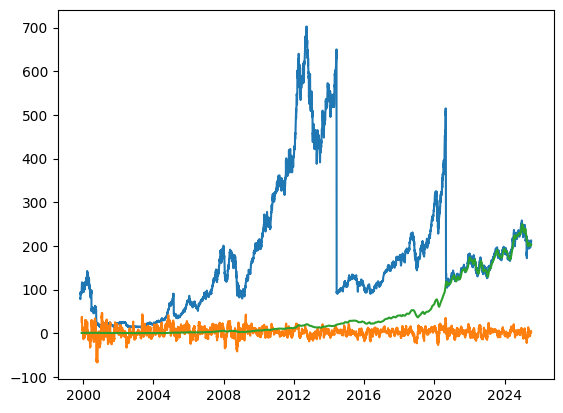

In [6]:
plt.plot(data['Open'])
plt.plot(roc)
plt.plot(sma)

In [7]:

data = data.sort_index()
data['Increase'] = (data['Close'] - data['Close'].shift(7)) / data['Close'].shift(7)
data = data.dropna(subset=['Increase'])
data = data.round(2)

### Seperating test and train data

In [8]:
train_data = data.loc['2012-02-01' : '2022-04-06']
test_data = data.loc['2022-04-07' : '2025-01-01']
print(train_data)

              Open    High     Low   Close       Volume  Increase
date                                                             
2012-02-01  458.41  458.99  455.55  456.19    9644500.0      0.07
2012-02-02  455.90  457.17  453.98  455.12    6671300.0      0.08
2012-02-03  457.30  460.00  455.56  459.68   10235700.0      0.03
2012-02-06  458.38  464.98  458.20  463.97    8907600.0      0.04
2012-02-07  465.25  469.75  464.58  468.83   11293700.0      0.05
...            ...     ...     ...     ...          ...       ...
2022-03-31  177.84  178.03  174.40  174.61  103049285.0      0.03
2022-04-01  174.03  174.88  171.94  174.31   78751328.0      0.02
2022-04-04  174.57  178.49  174.44  178.44   76545983.0      0.03
2022-04-05  177.50  178.30  174.42  175.06   70902999.0      0.00
2022-04-06  172.36  173.63  170.13  171.83   89058782.0     -0.02

[2563 rows x 6 columns]


In [9]:
roc = roc.sort_index()
train_roc = roc.loc['2012-02-01' : '2022-04-06']
test_roc = roc.loc['2022-04-07' : '2025-01-01']

### Normalising data

In [10]:
from sklearn.preprocessing import MinMaxScaler
state_features = pd.DataFrame({
    'ROC': train_roc['ROC'],
    'Close': train_data['Close'],
    'Volume': train_data['Volume'],
    'Increase': train_data['Increase']
})
scaler = MinMaxScaler()
scaled_features_array = scaler.fit_transform(state_features)

scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)
print(scaled_data.head())

                 ROC     Close    Volume  Increase
date                                              
2012-02-01  0.615023  0.598068  0.012051  0.861111
2012-02-02  0.601129  0.596319  0.002956  0.870370
2012-02-03  0.599206  0.603772  0.013860  0.824074
2012-02-06  0.597216  0.610784  0.009797  0.833333
2012-02-07  0.618859  0.618728  0.017096  0.842593


In [11]:
test_features = pd.DataFrame({
    'ROC': test_roc['ROC'],
    'Close': test_data['Close'],
    'Volume': test_data['Volume'],
    'Increase': test_data['Increase']
})
scaled_test_features_array = scaler.transform(test_features)
scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

## Creating Deep Q Network

### Setting up environment

In [12]:
class environment:

    def __init__(self, original_data, scaled_state_data):
        self.data = original_data['Close']
        self.volume_data = original_data["Volume"] # Not used in state, but fine to keep if needed
        self.increase_data = original_data["Increase"]
        self.scaled_state_data = scaled_state_data 
        self.roc = roc
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []

    def step(self, action):

        
        trade = [] 
        if self.index < len(self.data) - 7:
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
                
            
            total = self.get_net_worth()
            holding = (self.num_shares * data.iloc[self.index]) / total
            trade.append(total)
            trade.append(holding)
            trade.append(action)
            self.action_history.append(action)
            sold_bought = action - holding
            if action > holding:
                to_buy = (action - holding) * total
                new_balance = self.balance - to_buy
                if new_balance >= 0:
                    
                    new_shares = to_buy / self.data.iloc[self.index]
                    self.balance -= to_buy
                    self.num_shares += new_shares
            elif action < holding:
                to_sell = (holding - action) * total
                shares_to_sell = to_sell / data.iloc[self.index]
                new_num_shares = self.num_shares - shares_to_sell
                if new_num_shares >= 0:
                    self.num_shares = new_num_shares
                    self.balance += to_sell
            
            
                
           
                
            
            trade.append(self.num_shares)
            trade.append(self.balance)
            
            trade.append(self.data.iloc[self.index])
            self.index += 1
            
            new_net_worth = self.get_net_worth()
            self.balance_history.append(old_net_worth)

            # The reward is the change in value
            reward = new_net_worth - old_net_worth
            
            self.trades.append(trade)
            self.total_reward += reward
            self.rewards.append(self.total_reward)
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = 0
        self.trend = None
        self.balance_history = []
        self.trades = []
    
    def get_net_worth(self):
        
        total = self.balance + (self.num_shares * self.data.iloc[self.index])
        return total
        
    def get_state(self):
        state = self.scaled_state_data.iloc[self.index].values.tolist()
        return state


### Training the model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Create the Stock Environment
env = environment(train_data, scaled_data)

# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 10
ACTIONS = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Initialize Q-networks
input_dim = 4
output_dim = 11
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, len(ACTIONS) - 1)  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()
        

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return
    
    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
 
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
steps_done = 0

for episode in range(episodes):
    state = env.get_state()
    done = False
    i = 0
    for i in range(len(train_data) - 1):
        # Select action
        action_index = select_action(state, epsilon)
       
        action = ACTIONS[action_index]
        reward, done = env.step(action)
        
        next_state = env.get_state()
        # Store transition in memory
        memory.append((state, action_index, reward, next_state))
        
        # Update state
        state = next_state

        # Optimize model
        optimize_model()
        steps_done += 1

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())


    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    env.reset()
    #print(episode)

## Testing

In [20]:
def test(env):
    
    # Reset the environment
    env.reset()  
    state = env.get_state()
    step = 0
    done = False
    action_history = []
    sum = 0
    
    while env.index < (len(env.data) - 7):
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]

        reward, done = env.step(action)
        sum += 1
        
        state = env.get_state()

        if done:
            break
   

In [21]:
test_env = environment(test_data, scaled_test_data)
test(test_env)

### Assigning history values to dates

In [22]:
dates = pd.bdate_range(start='2022-04-07', periods=len(test_env.balance_history))
balances = pd.DataFrame({'Date': dates, 'Balance': test_env.balance_history})
balances.set_index('Date', inplace=True)
print(balances)
print(policy_net(torch.FloatTensor(state).unsqueeze(0)).detach().numpy())

               Balance
Date                  
2022-04-07  100.000000
2022-04-08   99.047287
2022-04-11   97.025462
2022-04-12   97.919911
2022-04-13   99.200124
...                ...
2024-11-07  129.842057
2024-11-08  131.364809
2024-11-11  132.130894
2024-11-12  130.432605
2024-11-13  130.981573

[680 rows x 1 columns]
[[6.7342362 6.8493357 6.6312437 6.7368965 6.429358  6.472544  6.5797715
  6.626586  6.8205657 6.551816  6.6047087]]


In [23]:
print((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])

0.30981573178000105


### Plotting model performace against underlying stock price

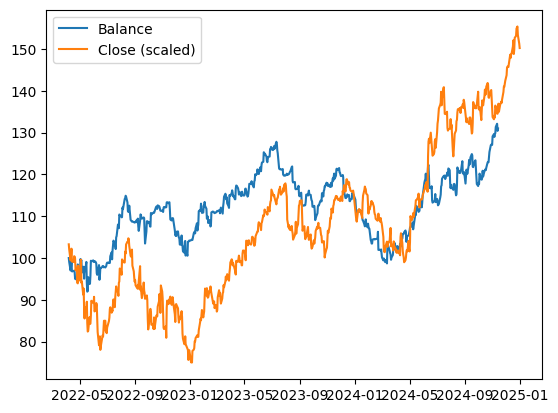

In [24]:
plt.plot(balances, label="Balance")
plt.plot(test_data["Close"] * 0.6, label="Close (scaled)")
plt.legend()
plt.show()
